In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc 
import numpy as np
import os
import pandas as pd

In [3]:
import celloracle as co
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180


In [4]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mLND3-1_v4.h5ad')
adata

AnnData object with n_obs × n_vars = 15836 × 3069
    obs: 'cluster', 'rctd_cluster', 'cell_type', 'cell_type_int'
    var: 'n_counts'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [5]:
oracle = co.load_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mLND3-1_v4.celloracle.oracle")
links = co.load_hdf5(file_path="/ix/djishnu/shared/djishnu_kor11/co_objects/mLND3-1_v4-links.celloracle.links")

In [ ]:
tfs = []
for cluster, df in links.links_dict.items():
    tfs.extend(df["source"].unique())

tfs = sorted(set(tfs))
len(tfs)

116

In [ ]:
tf = 'Pax5'
oracle.simulate_shift(perturb_condition={tf: 0})

In [ ]:
import json
with open('../../data/GSEA/m2.all.v2024.1.Mm.json', 'r') as f:
    gsea_modules = json.load(f)

In [11]:
import sys
sys.path.append('../../src')

In [ ]:
from spaceoracle.plotting.gsea import * 

gsea_scores = compute_gsea_scores(oracle.adata, gsea_modules)
gsea_scores_perturbed = compute_gsea_scores(oracle.adata, gsea_modules, layer='simulated_count')

Computing GSEA scores:  80%|███████▉  | 2156/2710 [59:16<1:12:16,  7.83s/it]

In [ ]:
delta_gsea_scores = gsea_scores - gsea_scores_perturbed
delta_gsea_scores.dropna(inplace=True)

delta_gsea_scores['abs_mean'] = delta_gsea_scores.iloc[:, :-1].apply(lambda row: np.abs(row.mean()), axis=1)
delta_gsea_scores.sort_values(by = 'abs_mean', ascending=False, inplace=True)

delta_gsea_scores = delta_gsea_scores.loc[delta_gsea_scores.index.str.contains('BIOCARTA')]
delta_gsea_scores

In [ ]:
show_gsea_scores(
    oracle.adata, delta_gsea_scores, annot='cell_type', n_show=9, 
    savepath=f'/ix/djishnu/shared/djishnu_kor11/co_results/mLDN3-1_v4/{tf}/gsea.png')

In [10]:
from spaceoracle.plotting.transitions import contour_shift
from spaceoracle.judges import Judge, permute_rows_nsign

judger = Judge(adata, annot='cell_type')


In [7]:
results_dir = '/ix/djishnu/shared/djishnu_kor11/co_results/mLDN3-1_v4'
st_dir = '/ix/djishnu/shared/djishnu_kor11/perturbations/mLDN3-1_v4'

os.makedirs(f'{results_dir}/{tf}', exist_ok=True)

In [ ]:
seed=1334

fig, axs = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1]})
axs.flatten()
contour_shift(oracle.adata, title=f'Cell Identity Shift from {tf} KO', annot='cell_type', seed=seed, ax=axs[0])

delta_X_rndm = oracle.adata.layers['delta_X'].copy()
permute_rows_nsign(delta_X_rndm)
fake_simulated_count = oracle.adata.layers['imputed_count'] + delta_X_rndm

contour_shift(oracle.adata, title=f'Randomized Effect of {tf} KO Shift', annot='cell_type', seed=seed, ax=axs[1], perturbed=fake_simulated_count)

plt.tight_layout()
plt.savefig(f'{results_dir}/{tf}/contour.png')

In [ ]:
nt = pd.DataFrame(oracle.adata.layers['imputed_count'], columns=oracle.adata.var_names)
co = pd.DataFrame(oracle.adata.layers['simulated_count'], columns=oracle.adata.var_names)
st = pd.read_parquet(f'{st_dir}/{tf}.parquet')

In [ ]:
co_sim_adata = judger.create_sim_adata(nt.values, co.values)
co_deg_df = judger.get_expected_degs(co_sim_adata, tf, show=30, save_path=results_dir+f'/{tf}/degs_CO.png')

In [ ]:
st_sim_adata = judger.create_sim_adata(nt.values, st.values)
st_deg_df = judger.get_expected_degs(st_sim_adata, tf, show=30, save_path=results_dir+f'/{tf}/degs_ST.png')

In [ ]:
judger.plot_delta_corr(nt=nt, co=co, pred=st, ko=tf, save_path=results_dir+f'/{tf}/delta_corr.png')

In [43]:
tf = 'Pax5'

results_dir = '/ix/djishnu/shared/djishnu_kor11/co_results/mLDN3-1_v4'
st_dir = '/ix/djishnu/shared/djishnu_kor11/perturbations/mLDN3-1_v4'

st = pd.read_parquet(f'{st_dir}/{tf}.parquet')
nt = pd.DataFrame(adata.layers['imputed_count'], columns=adata.var_names)
co = pd.read_parquet(f'{results_dir}/{tf}/simulated_count.parquet')

In [44]:
n_genes = 9
differences = abs(st - co.values).mean(axis=0)
top_genes = differences.nlargest(n_genes).index
top_genes= [st.columns.get_loc(gene) for gene in top_genes]
genes = adata.var_names[top_genes]
genes

Index(['Cd74', 'H2-Ab1', 'Cd79b', 'Eef1b2', 'Tmsb4x', 'Fth1', 'Lyz2', 'H2-D1', 'Ccl5'], dtype='object')

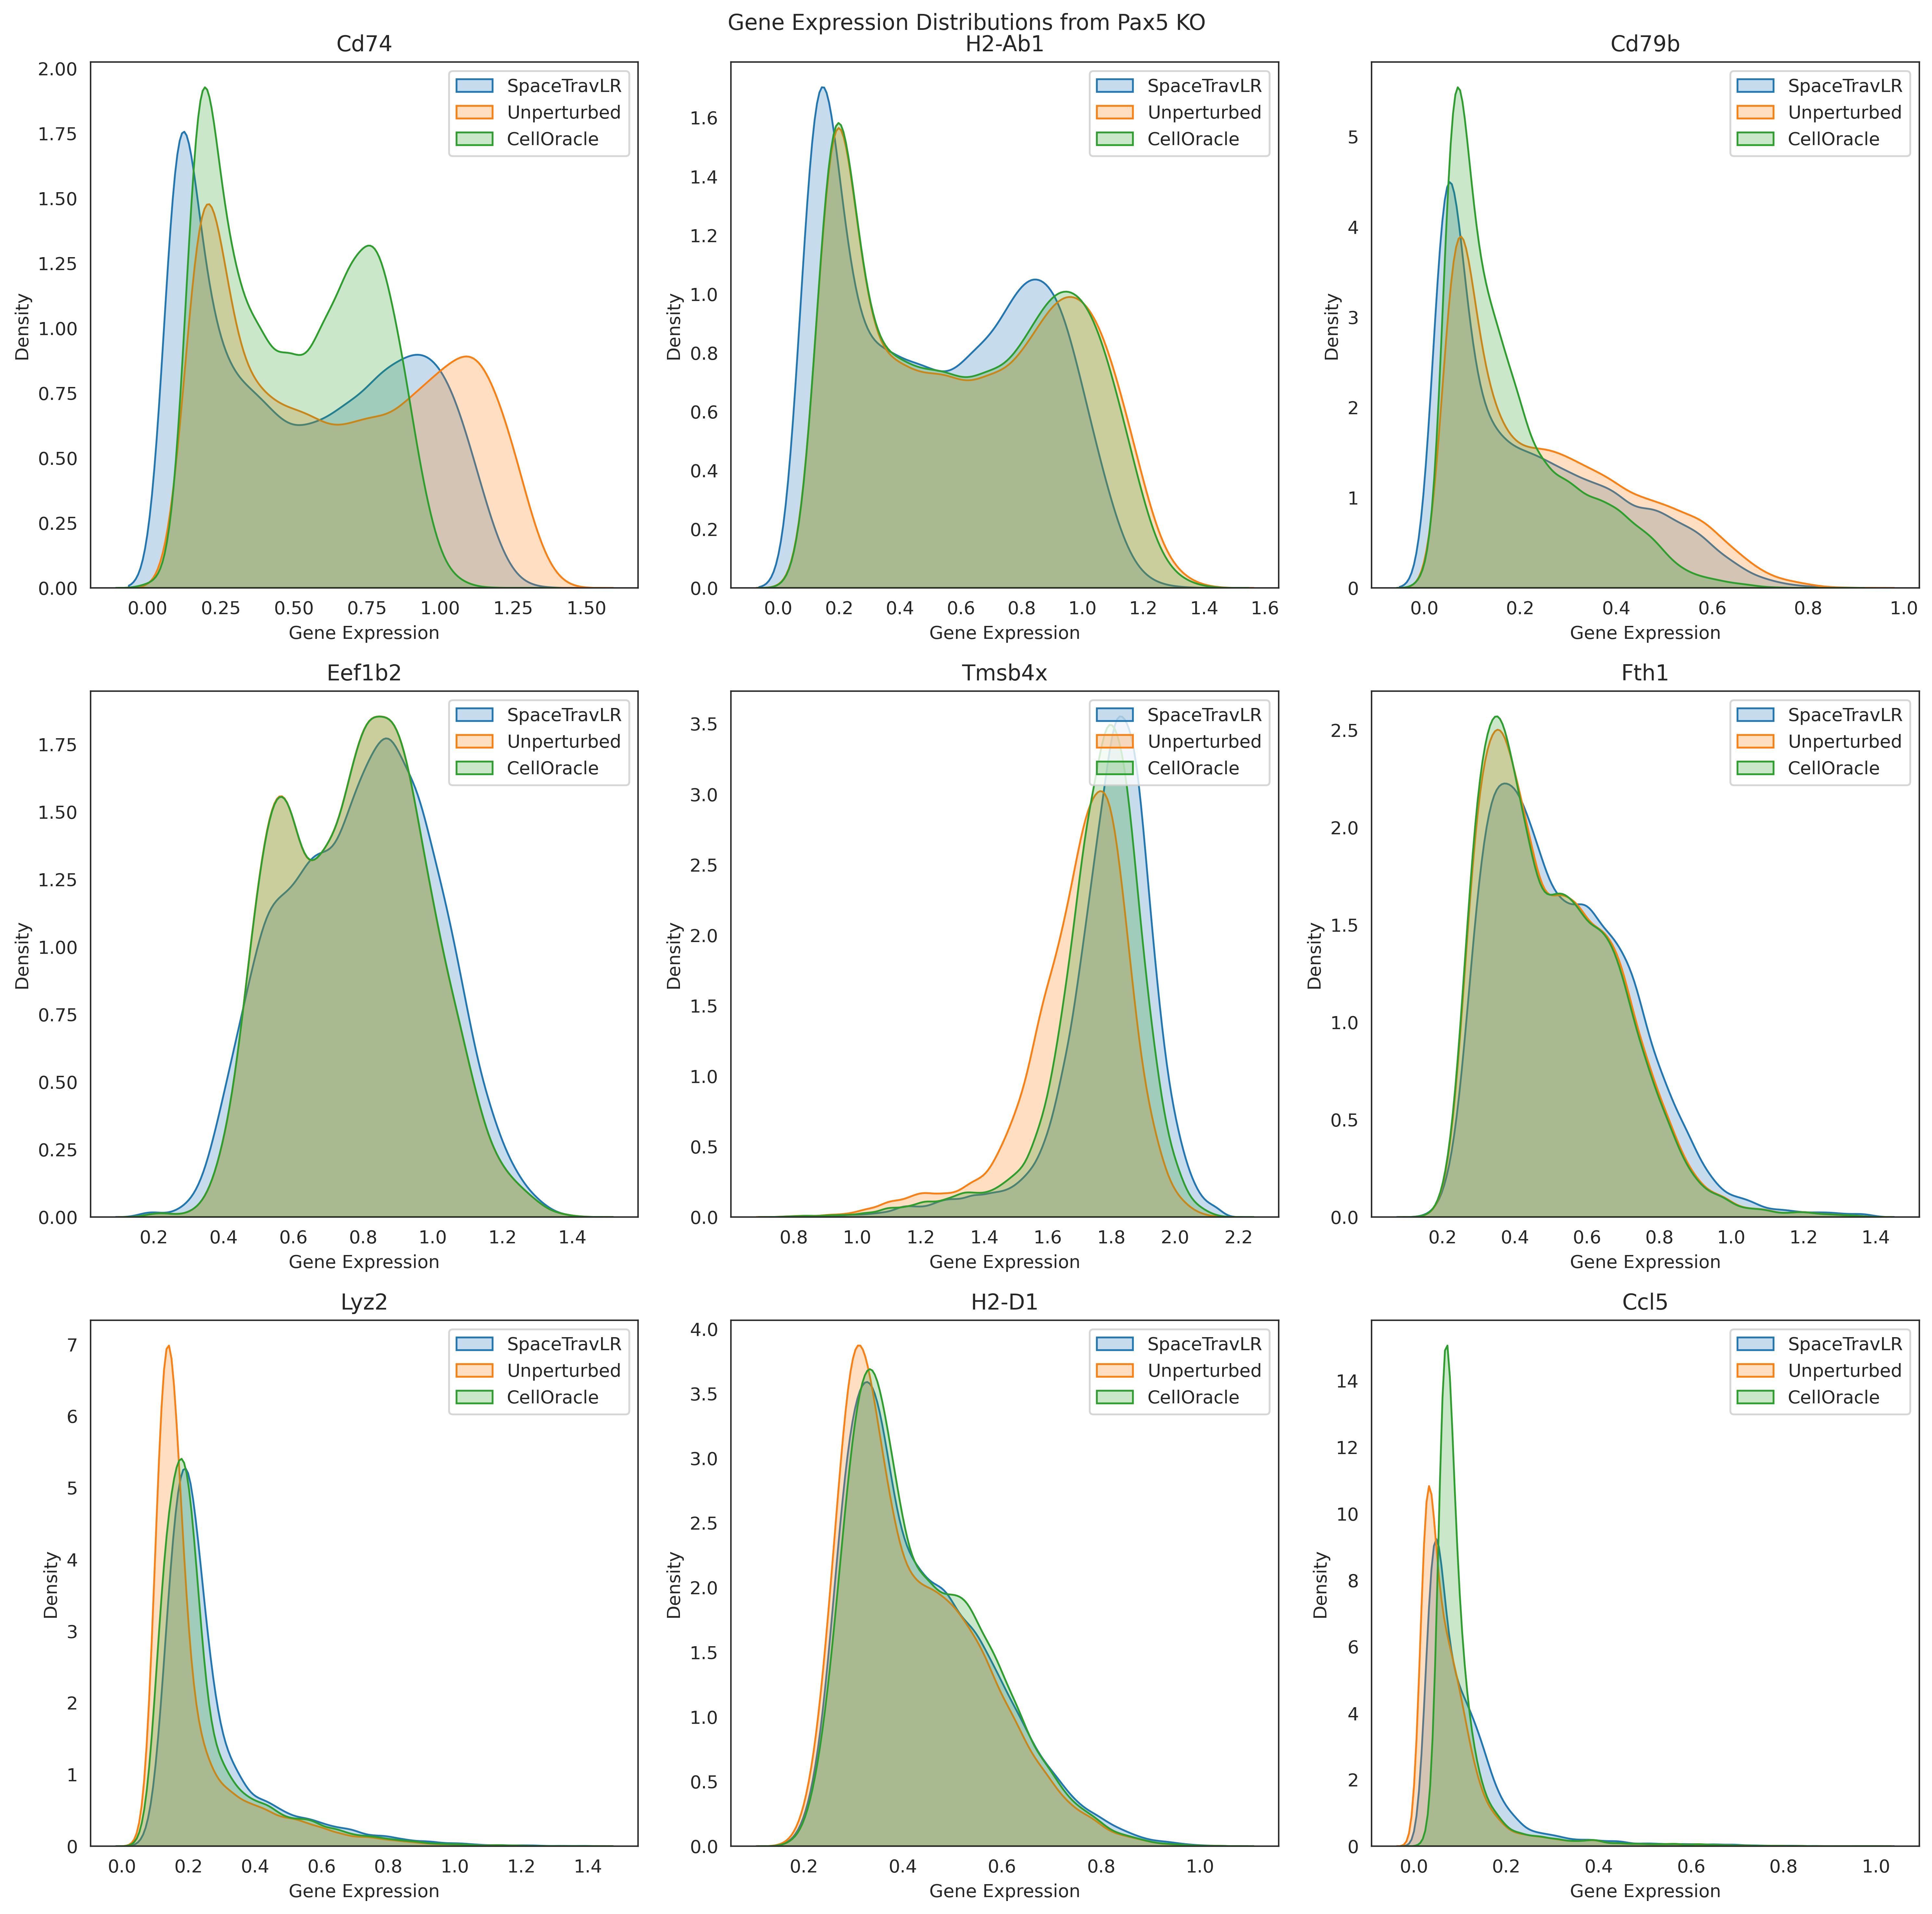

: 

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 15), dpi=200)
axs = axs.flatten()

for i, gene in enumerate(genes):
    sns.kdeplot(st[gene], label='SpaceTravLR', shade=True, ax=axs[i])
    sns.kdeplot(nt[gene], label='Unperturbed', shade=True, ax=axs[i])
    sns.kdeplot(co[gene], label='CellOracle', shade=True, ax=axs[i])
    axs[i].set_title(f'{gene}')
    axs[i].set_xlabel('Gene Expression')
    axs[i].set_ylabel('Density')
    axs[i].legend()

plt.suptitle(f'Gene Expression Distributions from {tf} KO')
plt.tight_layout()
plt.savefig(f'{results_dir}/{tf}/gex_distributions.png')
plt.show()
